
Comparing schedules with C=0.1145

Schedule 1 (γ₀/(1 + (γ₀/a)t)):
Training error: 0.1204
Test error: 0.1380

Schedule 2 (γ₀/(1 + t)):
Training error: 0.0952
Test error: 0.1180

Differences:
Weight vector norm difference: 0.0069
Bias difference: 0.0538
Training error difference: 0.0252
Test error difference: 0.0200


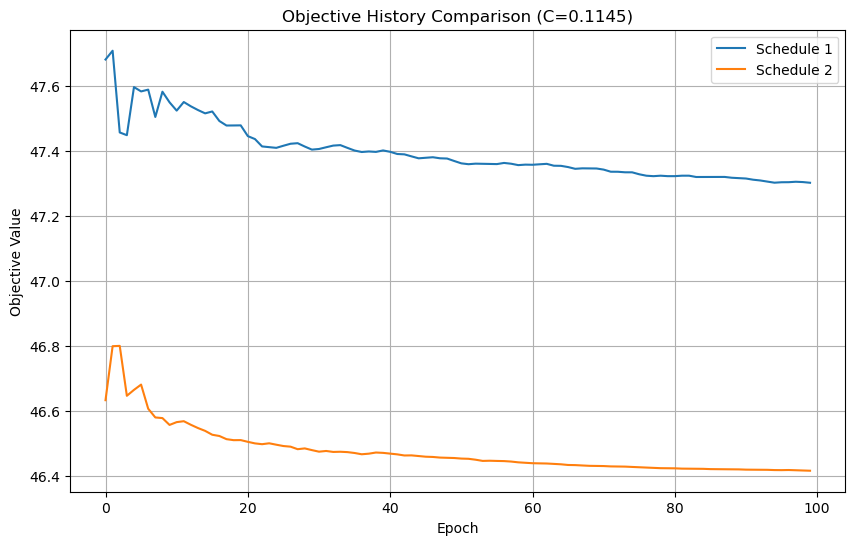


Comparing schedules with C=0.5727

Schedule 1 (γ₀/(1 + (γ₀/a)t)):
Training error: 0.0275
Test error: 0.0200

Schedule 2 (γ₀/(1 + t)):
Training error: 0.0241
Test error: 0.0200

Differences:
Weight vector norm difference: 0.0315
Bias difference: 0.1530
Training error difference: 0.0034
Test error difference: 0.0000


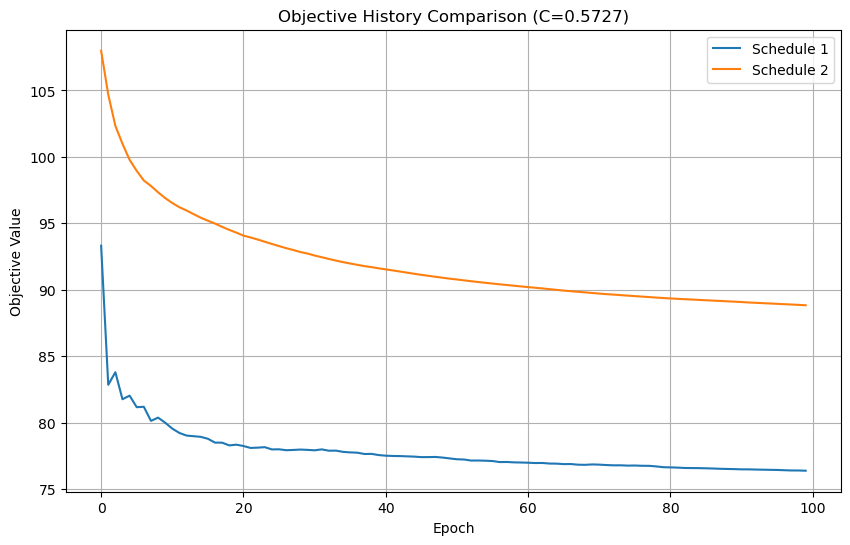


Comparing schedules with C=0.8018

Schedule 1 (γ₀/(1 + (γ₀/a)t)):
Training error: 0.0229
Test error: 0.0200

Schedule 2 (γ₀/(1 + t)):
Training error: 0.0241
Test error: 0.0180

Differences:
Weight vector norm difference: 0.0102
Bias difference: 0.0474
Training error difference: 0.0011
Test error difference: 0.0020


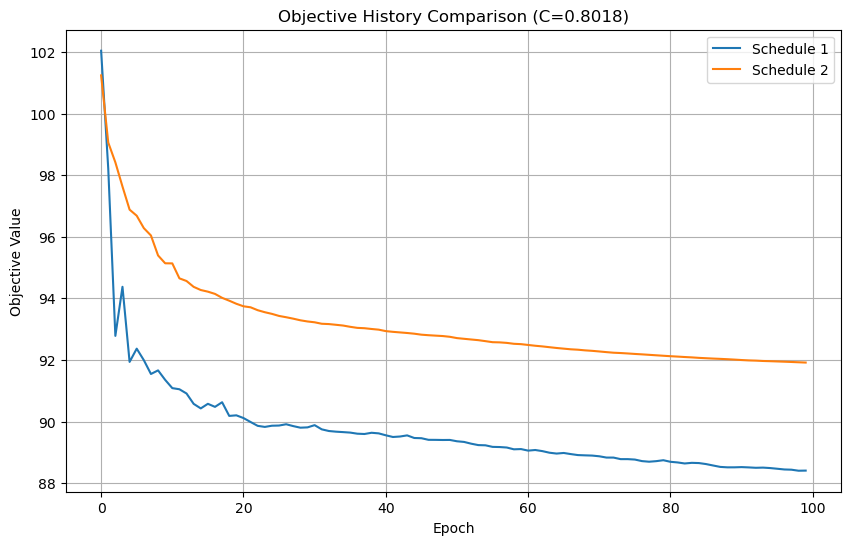


Summary of Results:
C	Schedule	Train Error	Test Error
--------------------------------------------------
0.1145	Schedule 1	0.1204		0.1380
0.1145	Schedule 2	0.0952		0.1180
--------------------------------------------------
0.5727	Schedule 1	0.0275		0.0200
0.5727	Schedule 2	0.0241		0.0200
--------------------------------------------------
0.8018	Schedule 1	0.0229		0.0200
0.8018	Schedule 2	0.0241		0.0180
--------------------------------------------------


In [2]:
import numpy as np
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt

class SVM:
    def __init__(self, C: float, gamma0: float, schedule_type: str, a: float = None, max_epochs: int = 100):
        """
        Initialize SVM with stochastic sub-gradient descent.
        
        Args:
            C: Regularization parameter
            gamma0: Initial learning rate
            schedule_type: Either 'schedule1' (γ₀/(1 + (γ₀/a)t)) or 'schedule2' (γ₀/(1 + t))
            a: Parameter for schedule1 (not used in schedule2)
            max_epochs: Maximum number of epochs
        """
        self.C = C
        self.gamma0 = gamma0
        self.schedule_type = schedule_type
        self.a = a
        self.max_epochs = max_epochs
        self.w = None
        self.b = 0
        self.objective_history = []
        
    def _learning_rate(self, t: int) -> float:
        """Calculate learning rate at step t using specified schedule"""
        if self.schedule_type == 'schedule1':
            return self.gamma0 / (1 + (self.gamma0 / self.a) * t)
        else:  # schedule2
            return self.gamma0 / (1 + t)
    
    def _calculate_objective(self, X: np.ndarray, y: np.ndarray) -> float:
        """Calculate the SVM objective function value"""
        reg_term = 0.5 * np.sum(self.w ** 2)
        margins = y * (X.dot(self.w) + self.b)
        hinge_losses = np.maximum(0, 1 - margins)
        hinge_term = self.C * np.sum(hinge_losses)
        return reg_term + hinge_term
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """Train the SVM using stochastic sub-gradient descent."""
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        t = 0
        
        for epoch in range(self.max_epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for i in range(n_samples):
                t += 1
                gamma_t = self._learning_rate(t)
                
                margin = y_shuffled[i] * (X_shuffled[i].dot(self.w) + self.b)
                
                if margin < 1:
                    self.w = (1 - gamma_t) * self.w + gamma_t * self.C * y_shuffled[i] * X_shuffled[i]
                    self.b += gamma_t * self.C * y_shuffled[i]
                else:
                    self.w = (1 - gamma_t) * self.w
            
            self.objective_history.append(self._calculate_objective(X, y))
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions for test data."""
        return np.sign(X.dot(self.w) + self.b)
    
    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """Calculate accuracy score."""
        return np.mean(self.predict(X) == y)

def compare_schedules(X_train: np.ndarray, y_train: np.ndarray, 
                     X_test: np.ndarray, y_test: np.ndarray,
                     C: float, gamma0: float, a: float) -> Dict:
    """Compare the two learning rate schedules."""
    
    # Train SVMs with both schedules
    svm1 = SVM(C=C, gamma0=gamma0, schedule_type='schedule1', a=a)
    svm2 = SVM(C=C, gamma0=gamma0, schedule_type='schedule2')
    
    svm1.fit(X_train, y_train)
    svm2.fit(X_train, y_train)
    
    # Calculate errors
    train_error1 = 1 - svm1.score(X_train, y_train)
    test_error1 = 1 - svm1.score(X_test, y_test)
    train_error2 = 1 - svm2.score(X_train, y_train)
    test_error2 = 1 - svm2.score(X_test, y_test)
    
    # Calculate parameter differences
    w_diff = np.linalg.norm(svm1.w - svm2.w)
    b_diff = abs(svm1.b - svm2.b)
    
    return {
        'schedule1': {
            'train_error': train_error1,
            'test_error': test_error1,
            'w': svm1.w,
            'b': svm1.b,
            'objective_history': svm1.objective_history
        },
        'schedule2': {
            'train_error': train_error2,
            'test_error': test_error2,
            'w': svm2.w,
            'b': svm2.b,
            'objective_history': svm2.objective_history
        },
        'differences': {
            'w_diff': w_diff,
            'b_diff': b_diff,
            'train_error_diff': abs(train_error1 - train_error2),
            'test_error_diff': abs(test_error1 - test_error2)
        }
    }

def load_and_preprocess_data(train_path: str, test_path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Load and preprocess the banknote data."""
    train_data = np.loadtxt(train_path, delimiter=',')
    test_data = np.loadtxt(test_path, delimiter=',')
    
    X_train, y_train = train_data[:, :-1], train_data[:, -1]
    X_test, y_test = test_data[:, :-1], test_data[:, -1]
    
    y_train = 2 * y_train - 1
    y_test = 2 * y_test - 1
    
    return X_train, y_train, X_test, y_test

def plot_comparison(results: Dict, C: float):
    """Plot objective function histories for both schedules."""
    plt.figure(figsize=(10, 6))
    plt.plot(results['schedule1']['objective_history'], label='Schedule 1')
    plt.plot(results['schedule2']['objective_history'], label='Schedule 2')
    plt.xlabel('Epoch')
    plt.ylabel('Objective Value')
    plt.title(f'Objective History Comparison (C={C:.4f})')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Load and preprocess data
    X_train, y_train, X_test, y_test = load_and_preprocess_data('train.csv', 'test.csv')
    
    # Parameters to test
    C_values = [100/873, 500/873, 700/873]
    gamma0 = 0.5  # Initial learning rate
    a = 1.0      # Schedule 1 parameter
    
    # Store all results
    all_results = []
    
    for C in C_values:
        print(f"\nComparing schedules with C={C:.4f}")
        
        results = compare_schedules(X_train, y_train, X_test, y_test, C, gamma0, a)
        all_results.append((C, results))
        
        # Print detailed comparison
        print("\nSchedule 1 (γ₀/(1 + (γ₀/a)t)):")
        print(f"Training error: {results['schedule1']['train_error']:.4f}")
        print(f"Test error: {results['schedule1']['test_error']:.4f}")
        
        print("\nSchedule 2 (γ₀/(1 + t)):")
        print(f"Training error: {results['schedule2']['train_error']:.4f}")
        print(f"Test error: {results['schedule2']['test_error']:.4f}")
        
        print("\nDifferences:")
        print(f"Weight vector norm difference: {results['differences']['w_diff']:.4f}")
        print(f"Bias difference: {results['differences']['b_diff']:.4f}")
        print(f"Training error difference: {results['differences']['train_error_diff']:.4f}")
        print(f"Test error difference: {results['differences']['test_error_diff']:.4f}")
        
        # Plot comparison
        plot_comparison(results, C)

    # Print summary table
    print("\nSummary of Results:")
    print("C\tSchedule\tTrain Error\tTest Error")
    print("-" * 50)
    for C, results in all_results:
        print(f"{C:.4f}\tSchedule 1\t{results['schedule1']['train_error']:.4f}\t\t{results['schedule1']['test_error']:.4f}")
        print(f"{C:.4f}\tSchedule 2\t{results['schedule2']['train_error']:.4f}\t\t{results['schedule2']['test_error']:.4f}")
        print("-" * 50)